In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer
from mpl_toolkits.mplot3d import Axes3D

In [2]:
train = pd.read_csv("./input/Train/train.csv")
test = pd.read_csv("./input/Test/test.csv")

print("shape of train: ", train.shape, "shape of test: ", test.shape)

shape of train:  (7767, 563) shape of test:  (3162, 563)


In [3]:
print(train.isnull().values.any())
print(test.isnull().values.any())

False
False


Observation: Train data and test data is divided in approximately 70:30. There are no missing values.

### Visualizations for Train data

In [4]:
print(train.Activity.value_counts())

STANDING              1423
LAYING                1413
SITTING               1293
WALKING               1226
WALKING_UPSTAIRS      1073
WALKING_DOWNSTAIRS     987
STAND_TO_LIE            90
SIT_TO_LIE              75
LIE_TO_SIT              60
LIE_TO_STAND            57
STAND_TO_SIT            47
SIT_TO_STAND            23
Name: Activity, dtype: int64


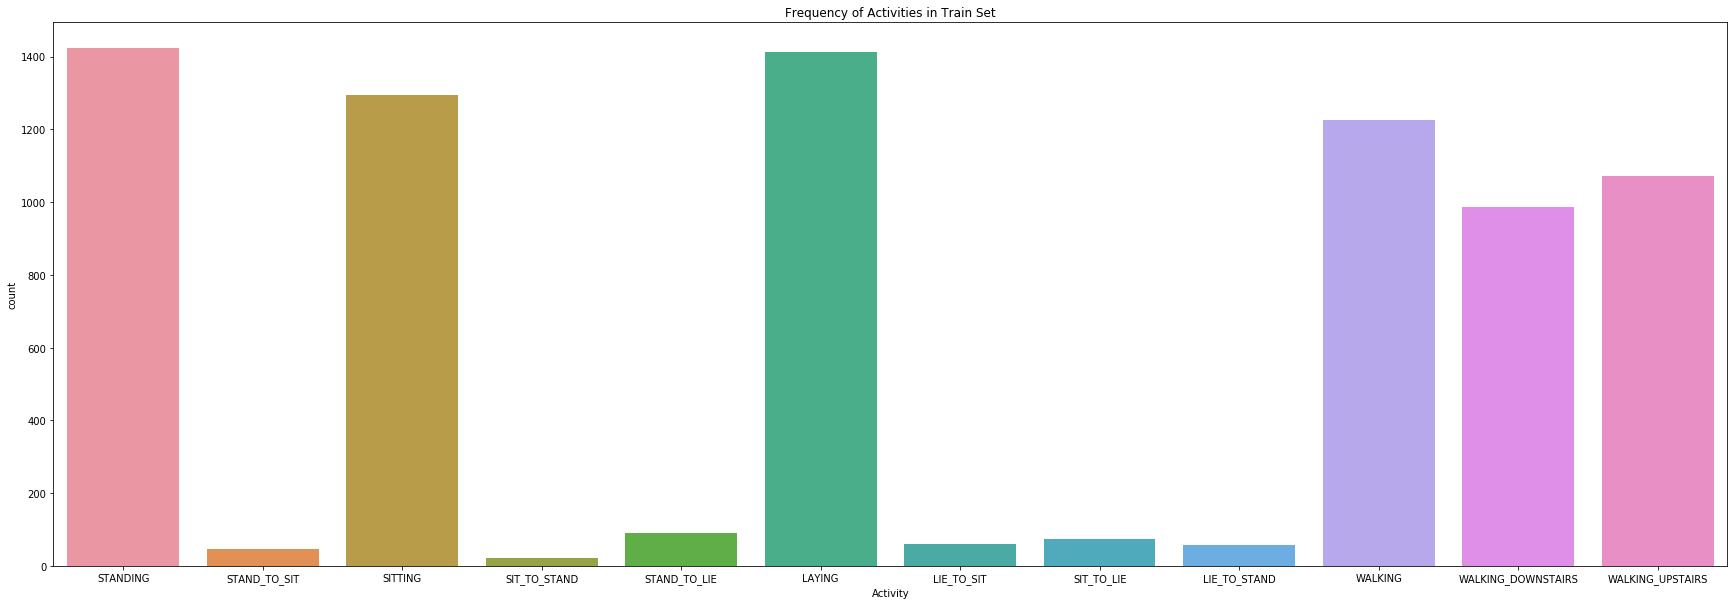

In [5]:
plt.figure(figsize = (30,10))
sns.countplot(x=train.Activity)
plt.xlabel('Activity')
plt.ylabel('count')
plt.title('Frequency of Activities in Train Set')
plt.show()

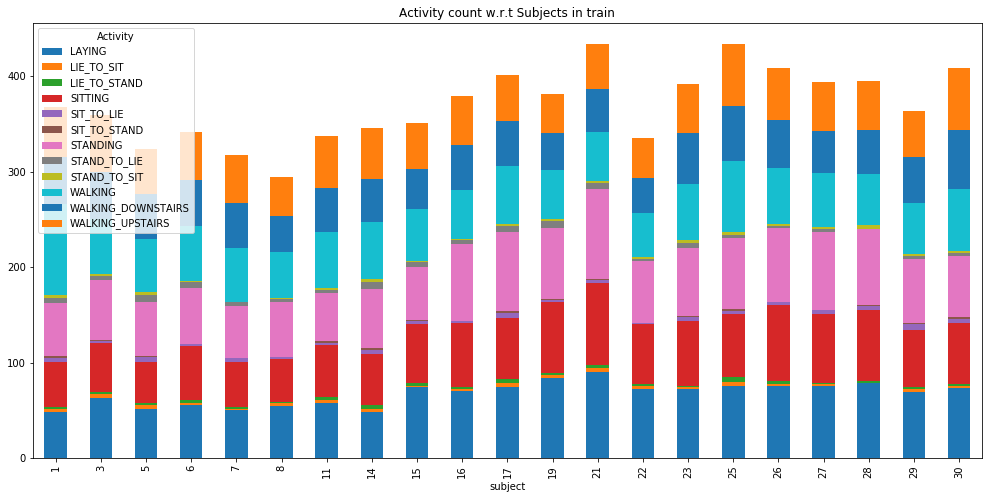

In [6]:
# Stacked Bar Chart for different activities with regards to subjects

stack_group = train.groupby(['subject', 'Activity']).size().unstack()
stack_group.plot(kind='bar', stacked=True, figsize=(17, 8), title = 'Activity count w.r.t Subjects in train')
plt.show()

### Visualizations for Test data

In [7]:
print(test.Activity.value_counts())

STANDING              556
LAYING                545
SITTING               508
WALKING               496
WALKING_UPSTAIRS      471
WALKING_DOWNSTAIRS    420
STAND_TO_LIE           49
SIT_TO_LIE             32
LIE_TO_STAND           27
LIE_TO_SIT             25
STAND_TO_SIT           23
SIT_TO_STAND           10
Name: Activity, dtype: int64


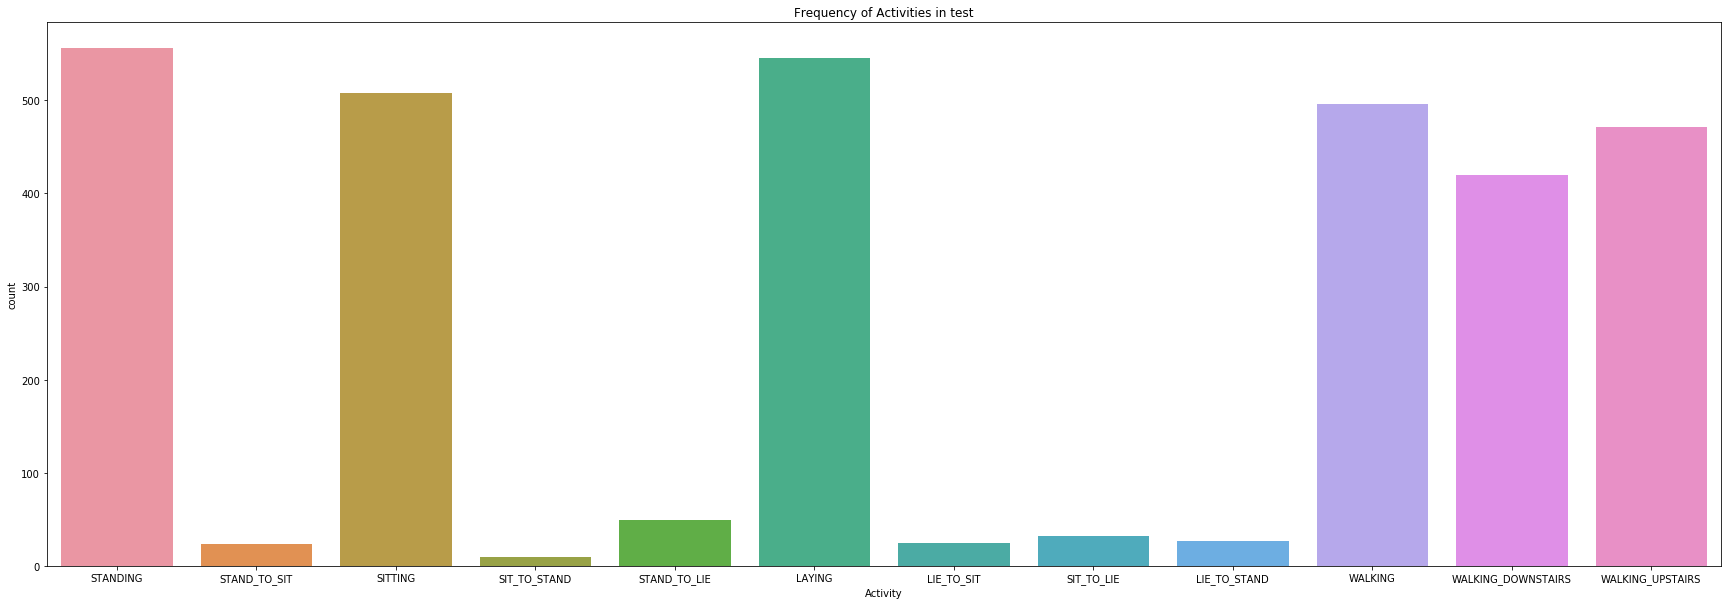

In [8]:
plt.figure(figsize = (30,10))
sns.countplot(x=test.Activity)
plt.xlabel('Activity')
plt.ylabel('count')
plt.title('Frequency of Activities in test')
plt.show()

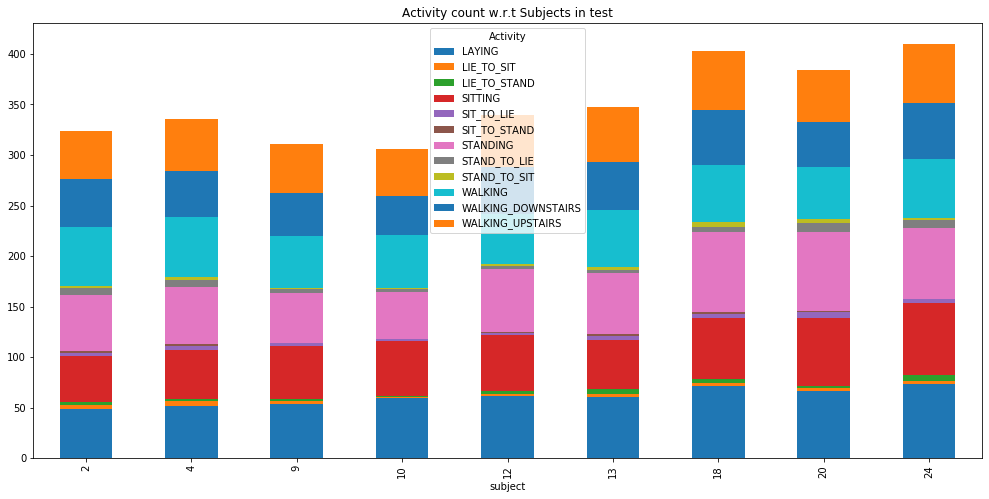

In [9]:
# Stacked Bar Chart for different activities with regards to subjects

stack_group = test.groupby(['subject', 'Activity']).size().unstack()
stack_group.plot(kind='bar', stacked=True, figsize=(17, 8), title = 'Activity count w.r.t Subjects in test')
plt.show()

### Principal Component Analysis (PCA)
We want to use PCA to reduce the the multidimension features in our data into fewer dimensions to better understand the data distribution. We are interested to find out whether the classes are separable using these selected principal components.

In [10]:
# First, we need to standardize the data to get better performance
from sklearn.preprocessing import StandardScaler
features = train.columns.values.tolist()
features.remove('Activity')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

#### 2 Components PCA

In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
PC = pca.fit_transform(x)
principalDf = pd.DataFrame(data = PC
             , columns = ['PC1', 'PC2'])

In [12]:
finalDf = pd.concat([principalDf, train[['Activity']]], axis = 1)

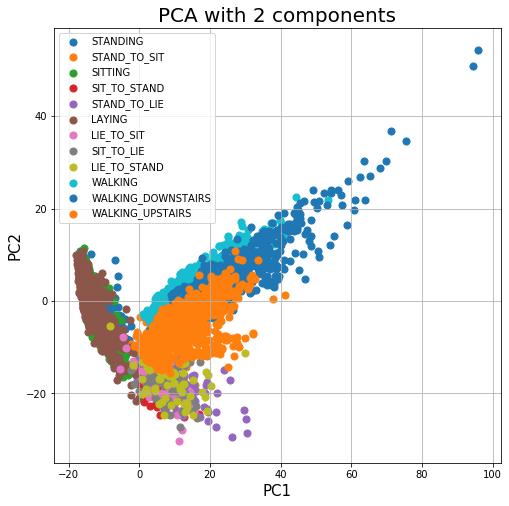

In [13]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_title('PCA with 2 components', fontsize = 20)
targets = train['Activity'].unique()

for target in targets:
    indicesToKeep = finalDf['Activity'] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'PC1']
               , finalDf.loc[indicesToKeep, 'PC2']
               , s = 50)
ax.legend(targets)
ax.grid()

In [14]:
pca.explained_variance_ratio_

array([0.4814824, 0.0808861])

From the result above we can see that the first principal component contains 48.15% of the variance and the second principal component contains 8.08% of the variance. Together, the two components contain 56.23% of the information, which is not very representative. The classes are also overlapping.

#### 3 Components PCA

In [59]:
pca3 = PCA(n_components=3)
PC3 = pca3.fit_transform(x)
principalDf3 = pd.DataFrame(data = PC3
             , columns = ['PC1', 'PC2', 'PC3'])

In [60]:
finalDf3 = pd.concat([principalDf3, train[['Activity']]], axis = 1)

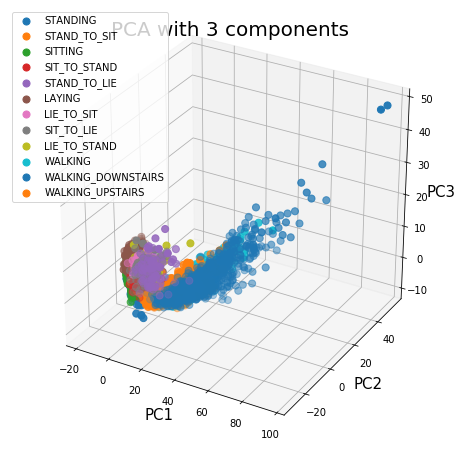

In [61]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1, projection='3d') 
ax.set_xlabel('PC1', fontsize = 15)
ax.set_ylabel('PC2', fontsize = 15)
ax.set_zlabel('PC3', fontsize = 15)
ax.set_title('PCA with 3 components', fontsize = 20)
targets = train['Activity'].unique()

for target in targets:
    indicesToKeep = finalDf3['Activity'] == target
    ax.scatter(finalDf3.loc[indicesToKeep, 'PC1']
               , finalDf3.loc[indicesToKeep, 'PC2']
               , finalDf3.loc[indicesToKeep, 'PC3']
               , s = 50)
ax.legend(targets)
ax.grid()

In [18]:
pca3.explained_variance_ratio_

array([0.4814824 , 0.0808861 , 0.03190478])

From the variance ratio above we can see that the first principal component contains 48.15% of the variance and the second principal component contains 8.08% of the variance, and the third principal component contains 3.19% of the variance. Together, the three components contain 59.42% of the information, which is still considerably small. The classes are again overlapping.

## Dimensionality Reduction using Isomap Embedding

In [57]:
# First, we need to standardize the data to get better performance
from sklearn.preprocessing import StandardScaler
features = train.columns.values.tolist()
features.remove('Activity')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [23]:
from sklearn.manifold import Isomap as ISO

iso = ISO(n_components = 2)
isomap = iso.fit_transform(x)
isomapTempDf = pd.DataFrame(data = isomap, columns = ["ISO1", "ISO2"])

In [24]:
isomapFinalDf = pd.concat([isomapTempDf, train[['Activity']]], axis = 1)

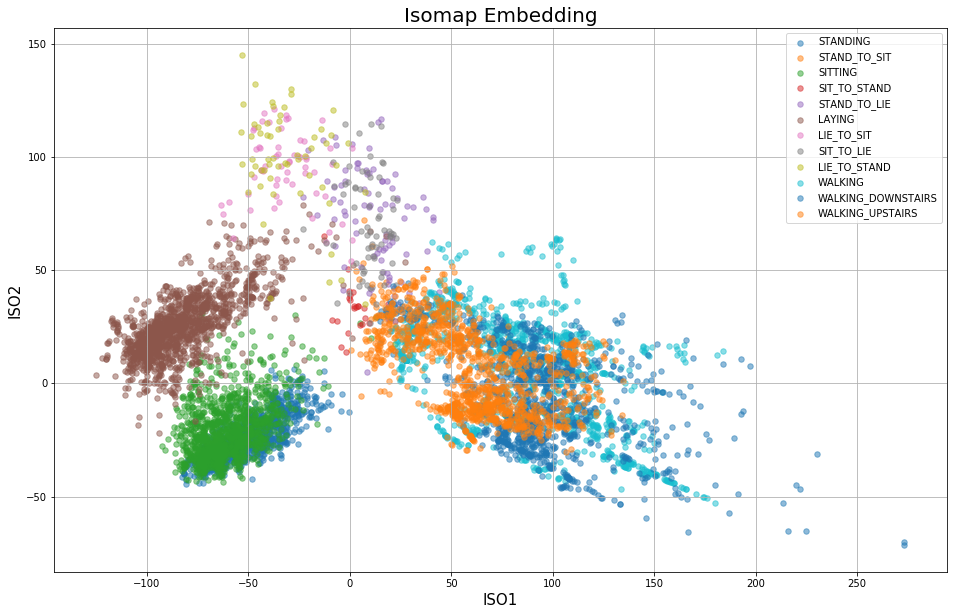

In [56]:
fig = plt.figure(figsize = (16,10))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('ISO1', fontsize = 15)
ax.set_ylabel('ISO2', fontsize = 15)
ax.set_title('Isomap Embedding', fontsize = 20)
targets = train['Activity'].unique()

for target in targets:
    indicesToKeep = isomapFinalDf['Activity'] == target
    ax.scatter(isomapFinalDf.loc[indicesToKeep, 'ISO1']
               , isomapFinalDf.loc[indicesToKeep, 'ISO2']
               , s = 30
               , alpha = 0.5)
ax.legend(targets)
ax.grid()

### t-Distributed Stochastic Neighbour Embedding (t-SNE)

In [26]:
# First, we need to standardize the data to get better performance
from sklearn.preprocessing import StandardScaler
features = train.columns.values.tolist()
features.remove('Activity')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

# Standardizing the features
x = StandardScaler().fit_transform(x)

In [27]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components = 2, perplexity = 50, n_iter = 7000)
tsne_results = tsne.fit_transform(x)

df_subset = pd.DataFrame(columns = ['tsne-2d-one','tsne-2d-two','Activities'])
df_subset['tsne-2d-one'] = tsne_results[:, 0]
df_subset['tsne-2d-two'] = tsne_results[:, 1]
df_subset['Activities'] = y

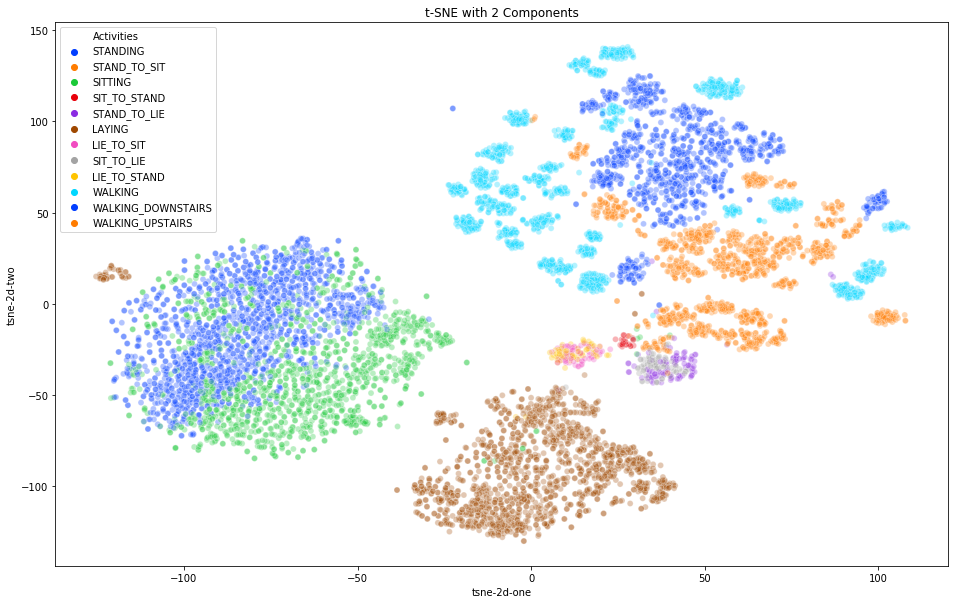

In [28]:
plt.figure(figsize = (16, 10))
plt.title('t-SNE with 2 Components')

sns.scatterplot(
    x = "tsne-2d-one", y = "tsne-2d-two",
    hue = "Activities",
    palette = "bright",
    data = df_subset,
    legend = "full",
    alpha = 0.3
)

plt.show()

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [30]:
features = train.columns.values.tolist()
features.remove('Activity')

# Separating out the features
x = train.loc[:, features].values

# Separating out the target
y = train.loc[:,['Activity']].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, random_state=1300)

In [31]:
dt = DecisionTreeClassifier()
dt.fit(x_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [32]:
dt.score(x_test, y_test)

0.9155509783728115

In [33]:
dt.score(x_train, y_train)

1.0

In [34]:
from sklearn.ensemble import RandomForestClassifier

In [35]:
clf_RF_n = [RandomForestClassifier(n_estimators = 50, random_state  = 1300),
            RandomForestClassifier(n_estimators = 150, random_state  = 1300),
            RandomForestClassifier(n_estimators = 200, random_state  = 1300),
            RandomForestClassifier(n_estimators = 400, random_state  = 1300),
            RandomForestClassifier(n_estimators = 500, random_state  = 1300)]

In [36]:
from sklearn.metrics import accuracy_score

acc_RF_n = []

for clf in clf_RF_n:
    fit = clf.fit(x_train, np.ravel(y_train))
    pred = fit.predict(x_test)
    accuracy = accuracy_score(y_test, pred)
    
    acc_RF_n.append(accuracy)

In [37]:
acc_RF_n

[0.9691040164778579,
 0.970648815653965,
 0.9696189495365602,
 0.9716786817713697,
 0.9727085478887745]

# Factor Analysis

We want to use Factor Analysis to find latent variables which can help us have a clearer interpretation of the variables and model.

In [38]:
# First, will need to create a factor analyzer variable
fac_analyzer = FactorAnalyzer(n_factors = 4, rotation = 'varimax')

# Dropping columns that are unnecessary or are non float.
fa_train = train.copy()
fa_train.drop(['subject', 'Activity'], axis = 1, inplace = True)

In [39]:
#Runs the factor analyzer
fac_analyzer.fit(fa_train)

C:\Users\daffa fathani a\anaconda3\lib\site-packages\factor_analyzer\utils.py:173: RuntimeWarning: divide by zero encountered in true_divide
  smc = 1 - 1 / np.diag(corr_inv)


FactorAnalyzer(bounds=(0.005, 1), impute='median', is_corr_matrix=False,
               method='minres', n_factors=4, rotation='varimax',
               rotation_kwargs={}, use_smc=True)

In [40]:
#Checks the eigen values of the analyzer
ev, v = fac_analyzer.get_eigenvalues()

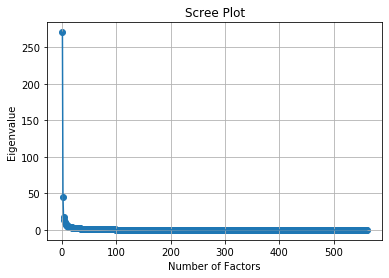

In [41]:
#Analysing the Scree plot
plt.scatter(range(1,fa_train.shape[1]+1),ev)
plt.plot(range(1,fa_train.shape[1]+1), ev)
plt.title("Scree Plot")
plt.xlabel("Number of Factors")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

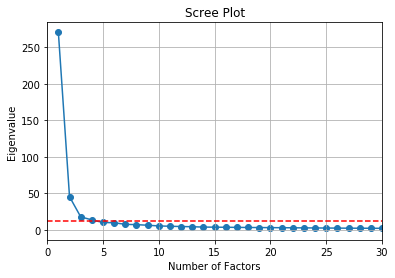

In [42]:
#Zooming in on the Scree plot
plt.scatter(range(1,fa_train.shape[1]+1),ev)
plt.plot(range(1,fa_train.shape[1]+1), ev)
plt.title("Scree Plot")
plt.xlabel("Number of Factors")
plt.ylabel("Eigenvalue")
plt.xlim(0, 30)
plt.grid()
plt.axhline(y = 12, color = 'r', linestyle = '--')
plt.show()

From the Scree plot above, we can see that the "elbow" of the graph is around ev = 12 and the number of factours is around 4-6. So factors to the left of the scree plot when y = 12 should be kept and seen as significant while those on the right are deemed as in significant.

In [43]:
#Filter out eigenvalues that are above 12
ev_greater_than1 = ev.copy()
ev_greater_than1 = ev_greater_than1[np.where(ev_greater_than1 > 12)]

#Number of eigenvalue > 12
no_ev_gt1 = len(ev_greater_than1) # = 4

In [44]:
#Showing the Weights of each variable as a factor to see which features can be considered, sorted in descending order
pd.DataFrame(fac_analyzer.loadings_, columns = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'], index = [fa_train.columns]).sort_values(by = ['Factor 1', 'Factor 2', 'Factor 3', 'Factor 4'], ascending = False)

,Factor 1,Factor 2,Factor 3,Factor 4
tBodyAccJerk-STD-1,0.955349,0.029652,0.083073,0.217267
tBodyAccJerk-Mad-1,0.955236,0.026521,0.080242,0.216465
fBodyAccJerk-Mean-1,0.955213,0.032790,0.088492,0.207901
tBodyAccJerkMag-SMA-1,0.953485,0.042498,0.144872,0.232404
tBodyAccJerkMag-Mean-1,0.953485,0.042498,0.144872,0.232404
...,...,...,...,...
tBodyAcc-Min-2,-0.880259,-0.230537,-0.079229,-0.182246
tBodyGyroJerk-Min-1,-0.885121,-0.042316,-0.090337,-0.207431
tBodyAcc-Min-1,-0.896222,-0.227784,-0.073784,-0.151554
tBodyAccJerk-Min-1,-0.901442,-0.058534,-0.091220,-0.259017


In [45]:
#Communality of Loading, where values closer to 1 means that that factor explain more of the variance
pd.DataFrame(fac_analyzer.get_communalities(), columns = ["Communalities"], index = [fa_train.columns]).sort_values(by = "Communalities", ascending = False)

,Communalities
fBodyAccJerk-SMA-1,0.986456
tBodyAccJerkMag-SMA-1,0.985940
tBodyAccJerkMag-Mean-1,0.985940
tBodyAccJerk-SMA-1,0.985750
fBodyAcc-SMA-1,0.983543
...,...
tBodyAccJerk-Mean-3,0.003149
tBodyGyroJerk-AngleWRTGravity-1,0.003089
tBodyGyroJerk-Mean-2,0.001114
tBodyAccJerk-Mean-1,0.001005


In [46]:
# Showing the Sum of Squared Loading (Variance), Proportional Variance, and Cumulative Variance caused by the 4 factors.
pd.DataFrame(fac_analyzer.get_factor_variance(), columns = ["Factor 1", "Factor 2", "Factor 3", "Factor 4"], index = ["Sum Square Loading", "Proportional Variance", "Cumulative Variance"])

,Factor 1,Factor 2,Factor 3,Factor 4
Sum Square Loading,237.556767,52.591372,30.002448,26.131142
Proportional Variance,0.423452,0.093746,0.053480,0.046580
Cumulative Variance,0.423452,0.517198,0.570678,0.617258


From the table above, it can be seen that using four factors,  can explain around 61% of the variance, which is considered valid but maybe still small (Recommended is > 60% and this is very close to it).